# Подготовка сессии

In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pandas as pd 
import numpy as np
import glob
from tqdm import tqdm
import cv2
from sklearn.model_selection import train_test_split

!pip install git+https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import resnet18
from torchvision.utils import draw_segmentation_masks

from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")
torch.manual_seed(17)

import json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-ui_r_u5d
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-ui_r_u5d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd ./drive/MyDrive/Tournaments/Hackai/EyesSegmentation/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/MyDrive/Tournaments/Hackai/EyesSegmentation


## Датасет

Прежде чем разбираться с моделями, нам надо в первую очередь разобраться с тем, как грузить датасет. Давайте напишем класс в торче для этого.

In [3]:
class EyeDataset(Dataset):
    """
    Класс датасета, организующий загрузку и получение изображений и соответствующих разметок
    """

    def __init__(self, data_folder: str, phase, transform = None):
        self.class_ids = {"vessel": 1}

        self.data_folder = data_folder
        self.transform = transform
        self.phase = phase
        self._image_files = glob.glob(f"{data_folder}/*.png")

    @staticmethod
    def read_image(path: str) -> np.ndarray:
        image = cv2.imread(str(path), cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = np.array(image / 255, dtype=np.float32)
        return image

    @staticmethod
    def parse_polygon(coordinates: dict, image_size: tuple, mask) -> np.ndarray:
        if len(coordinates) == 1:
            points = [np.int32(coordinates)]
            cv2.fillPoly(mask, points, 1)
        else:
            points = [np.int32([coordinates[0]])] 
            cv2.fillPoly(mask, points, 1) 
 
            for polygon in coordinates[1:]: 
              points = [np.int32([polygon])] 
              cv2.fillPoly(mask, points, 0) 
        return mask

    @staticmethod
    def parse_mask(shape: dict, image_size: tuple, mask) -> np.ndarray:
        """
        Метод для парсинга фигур из geojson файла
        """
        coordinates = shape['coordinates']
        if shape['type'] == 'MultiPolygon':
            for polygon in coordinates:
                mask = EyeDataset.parse_polygon(polygon, image_size, mask)
        else:
            mask = EyeDataset.parse_polygon(coordinates, image_size, mask)
        mask = np.clip(mask, 0, 1)
        return mask

    def read_layout(self, path: str, image_size: tuple) -> np.ndarray:
        """
        Метод для чтения geojson разметки и перевода в numpy маску
        """
        with open(path, 'r', encoding='cp1251') as f:  # some files contain cyrillic letters, thus cp1251
            json_contents = json.load(f)

        num_channels = 1
        mask = np.zeros(image_size, dtype=np.float32)

        if type(json_contents) == dict and json_contents['type'] == 'FeatureCollection':
            features = json_contents['features']
        elif type(json_contents) == list:
            features = json_contents
        else:
            features = [json_contents]

        for shape in features:
            mask = self.parse_mask(shape['geometry'], image_size, mask)

        return mask

    def __getitem__(self, idx: int) -> dict:
        # Достаём имя файла по индексу
        image_path = self._image_files[idx]
        if self.phase == 'test':
          image = self.read_image(image_path)
          sample = {'image': image}
          
          if self.transform is not None:
              sample = self.transform['test'](image=image)
        else:
          # Получаем соответствующий файл разметки
          json_path = image_path.replace("png", "geojson")

          image = self.read_image(image_path)

          mask = self.read_layout(json_path, image.shape[:2])

          sample = {'image': image,
                    'mask': mask}

          if self.transform is not None:
              sample = self.transform['train'](image=image, mask=mask)

        return sample

    def __len__(self):
        return len(self._image_files)

    # Метод для проверки состояния датасета
    def make_report(self):
      reports = []
      if (not self.data_folder):
        reports.append("Путь к датасету не указан")
      if (len(self._image_files) == 0):
        reports.append("Изображения для распознавания не найдены")
      else:
        reports.append(f"Найдено {len(self._image_files)} изображений")
      cnt_images_without_masks = sum([1 - len(glob.glob(filepath.replace("png", "geojson"))) for filepath in self._image_files])
      if cnt_images_without_masks > 0:
        missing_files = [filepath for filepath in self._image_files if 0 == len(glob.glob(filepath.replace("png", "geojson")))]
        reports.append(f"Найдено {cnt_images_without_masks, missing_files} изображений без разметки")
      else:
        reports.append(f"Для всех изображений есть файл разметки")
      return reports


class DatasetPart(Dataset):
    """
    Обертка над классом датасета для его разбиения на части
    """
    def __init__(self, dataset: Dataset,
                 indices: np.ndarray,
                 transform: A.Compose = None):
        self.dataset = dataset
        self.indices = indices

        self.transform = transform

    def __getitem__(self, idx: int) -> dict:
        sample = self.dataset[self.indices[idx]]

        return sample

    def __len__(self) -> int:
        return len(self.indices)


In [4]:
# Задаем преобразование изображений
train_list = [A.PadIfNeeded(1024, 1024),
              A.CenterCrop(height = 1024, width = 1024),
              A.HorizontalFlip(),
              ToTensorV2()
              ] 

test_list = [A.PadIfNeeded(1024, 1024),
              A.CenterCrop(height = 1024, width = 1024),
              ToTensorV2()
              ] 

transforms = {'train': A.Compose(train_list), 'test': A.Compose(test_list)}

In [5]:
# Инициализируем датасет
train_root = "train"
dataset = EyeDataset(train_root, phase = 'train', transform = transforms)

In [6]:
# Проверим состояние загруженного датасета
for msg in dataset.make_report():
  print(msg)

Найдено 652 изображений
Для всех изображений есть файл разметки


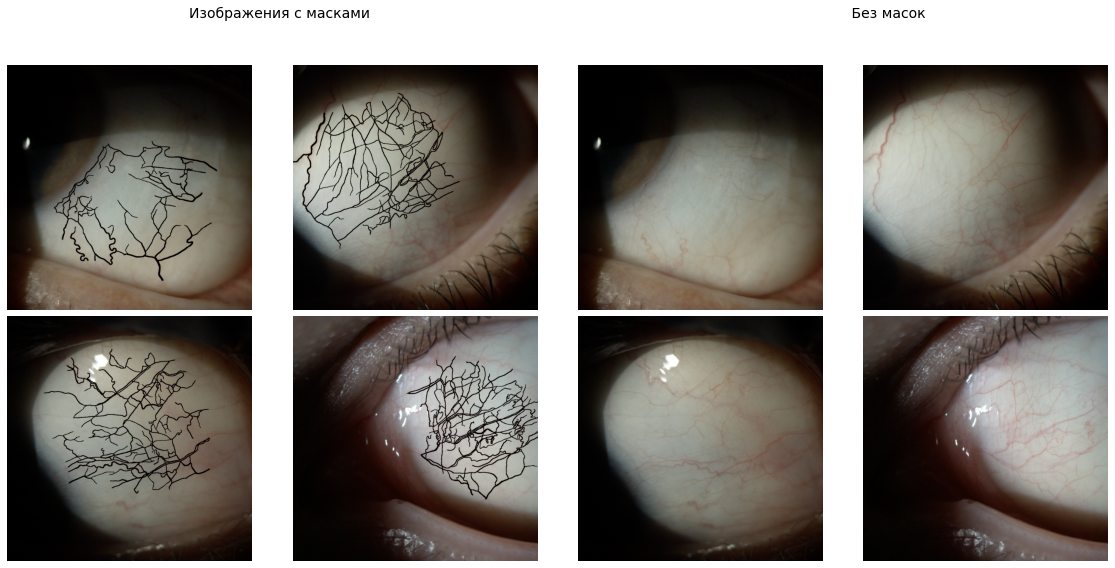

In [7]:
# Посмотрим на картинки из датасета

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Изображения с масками {" "*105} Без масок', fontsize=14)

for i in range(4):
    sample = dataset[i]
    image = sample['image']
    mask = sample['mask']

    image_with_mask = draw_segmentation_masks((image * 255).type(torch.uint8), mask.type(torch.bool), alpha = 1)
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')

    image = np.moveaxis(image.cpu().numpy(), 0, -1)    
    axs[i // 2, (i % 2)+2].imshow(image)
    axs[i // 2, (i % 2)+2].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [8]:
from os import listdir

print("Обучающей выборки " ,len(listdir("train")) // 2)
print("Тестовой выборки " ,len(listdir("test/eye_test")))

Обучающей выборки  655
Тестовой выборки  301


In [9]:
# разделим датасет на тренировочный и валидационный, чтобы смотреть на качество
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2)
#train_indices = range(len(dataset))

In [10]:
print(f"Разбиение на train/test : {len(train_indices)}/{len(test_indices)}")

Разбиение на train/test : 521/131


In [11]:
# Разбиваем объект датасета на тренировачный и валидационный
train_dataset = DatasetPart(dataset, train_indices, transforms)
valid_dataset = DatasetPart(dataset, test_indices, transforms)

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, 4,
                                   shuffle=True, drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 4,
                                   shuffle=True, drop_last=True)

## Вспомогательные функции

In [13]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

# Класс тренировщика модели

In [14]:
from typing import Tuple, List, Callable, Iterator, Optional, Dict, Any
from collections import defaultdict

def train(model, iterator, criterion, clip = None, optimizer = None, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    matrix = []
    for i, batch in enumerate(iterator):

        x = batch['image'].to(device)
        y = batch['mask'].to(device)

        optimizer.zero_grad()
        
        output = model(x).squeeze()
        
        loss = criterion(output, y)

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        history.append(loss.cpu().data.numpy())

        prob_mask = output.sigmoid().cpu()
        pred_mask = (prob_mask > 0.5).float()
        tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), y.long().cpu(), mode="binary")
        matrix.append({
            "tp": tp,
            "fp": fp,
            "fn": fn,
            "tn": tn,
        })
        
        if (i+1)%20==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

    tp = torch.cat([x["tp"] for x in matrix])
    fp = torch.cat([x["fp"] for x in matrix])
    fn = torch.cat([x["fn"] for x in matrix])
    tn = torch.cat([x["tn"] for x in matrix])
    per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
    dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    epoch_f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction = "micro")
    
    return epoch_loss / len(iterator), [per_image_iou, dataset_iou, epoch_f1]

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    matrix = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            x = batch['image'].to(device)
            y = batch['mask'].to(device)

            output = model(x).squeeze()

            loss = criterion(output, y)
            
            epoch_loss += loss.item()
            
            prob_mask = output.sigmoid().cpu()
            pred_mask = (prob_mask > 0.5).float()
            tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), y.long().cpu(), mode="binary")
            matrix.append({
                "tp": tp,
                "fp": fp,
                "fn": fn,
                "tn": tn,
            })

    tp = torch.cat([x["tp"] for x in matrix])
    fp = torch.cat([x["fp"] for x in matrix])
    fn = torch.cat([x["fn"] for x in matrix])
    tn = torch.cat([x["tn"] for x in matrix])
    per_image_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro-imagewise")
    dataset_iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    epoch_f1 = smp.metrics.f1_score(tp, fp, fn, tn, reduction = "micro")
    
    return epoch_loss / len(iterator), [per_image_iou, dataset_iou, epoch_f1]

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [15]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output
import time
import math

In [16]:
torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = smp.Unet('resnet34', encoder_weights="imagenet", in_channels=3, classes=1).to(device)

criterion = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer = torch.optim.Adam(model.parameters(), 0.0001)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

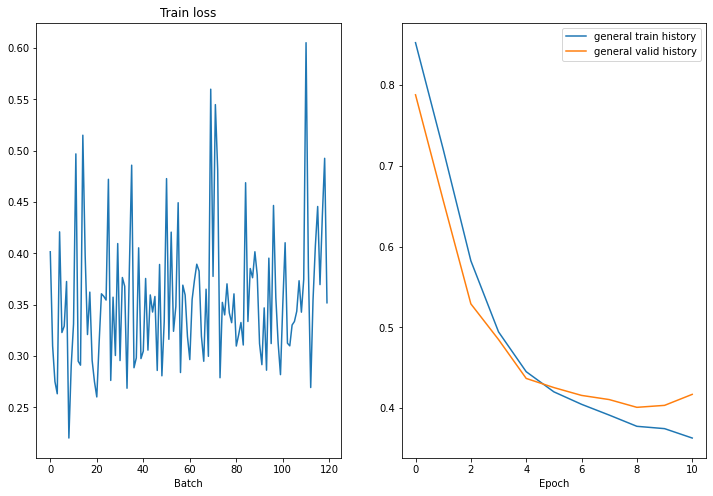

Epoch: 12 | Time: 4m 27s
	Train Loss: 0.353
	 Val. Loss: 0.410
	 Train im_iou: 0.480 |  Train dataset_iou: 0.495 |  Train f1: 0.662
	 Val. im_iou: 0.429 |  Val. dataset_iou: 0.432 |  Val. f1: 0.604


In [17]:
train_history = []
valid_history = [] 
train_metrics = []
val_metrics = []

N_EPOCHS = 12
best_valid_loss = float('inf')
 
for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_metrics = train(model, train_loader, criterion, optimizer = optimizer, train_history = train_history, valid_history = valid_history)
    valid_loss, val_metrics = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'models_weights/best_val_Unet_resnet50_10epoch.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')
    print(f'\t Train im_iou: {train_metrics[0]:.3f} |  Train dataset_iou: {train_metrics[1]:.3f} |  Train f1: {train_metrics[2]:.3f}')
    print(f'\t Val. im_iou: {val_metrics[0]:.3f} |  Val. dataset_iou: {val_metrics[1]:.3f} |  Val. f1: {val_metrics[2]:.3f}')

In [18]:
torch.save(model.state_dict(), 'models_weights/end_Unet_resnet50_10epoch.pt')

## Модель

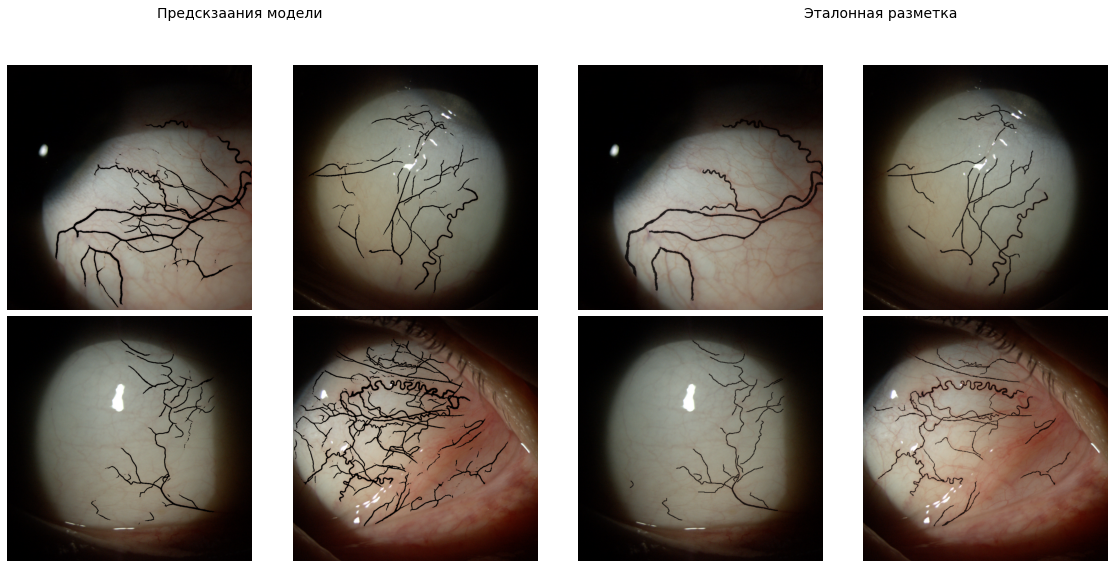

In [19]:
# Посмотрим на картинки предсказаний

fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Предскзаания модели {" "*105} Эталонная разметка', fontsize=14)

for i, sample in zip(range(4), valid_dataset):
    image = sample['image'].to("cuda")
    true_mask = sample['mask'].to("cuda")

    prediction = model.eval()(image.unsqueeze(dim=0))

    image = (image.cpu() * 255).type(torch.uint8)
    pred_ask = (torch.exp(prediction[0]) > 0.5).cpu()

    image_with_mask = draw_segmentation_masks(image, pred_ask, alpha = 1)
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')


    image_with_mask = draw_segmentation_masks(image, true_mask.type(torch.bool))
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)
    axs[i // 2, (i % 2)+2].imshow(image_with_mask)
    axs[i // 2, (i % 2)+2].axis('off')


fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [20]:
test_root = "test/eye_test"
dataset_test = EyeDataset(test_root, phase = 'test', transform=transforms)

In [21]:
test_dataset = DatasetPart(dataset_test, range(len(dataset_test)), transform=transforms)

test_loader = torch.utils.data.DataLoader(test_dataset, 1,
                                   shuffle=False)

In [22]:
def inference(model, test_iterator): 
        predictions = []
        model.eval()
        
        with torch.no_grad():
          for batch in test_iterator:

              xs = batch['image'].to(device)
              ys_pred = model(xs)

              predictions.append(ys_pred)

        return predictions

In [23]:
model.load_state_dict(torch.load('models_weights/best_val_Unet_resnet50_10epoch.pt'))
test_pred = inference(model, test_loader)

torch.Size([1024, 1024])
torch.Size([1024, 1024])
torch.Size([1024, 1024])
torch.Size([1024, 1024])


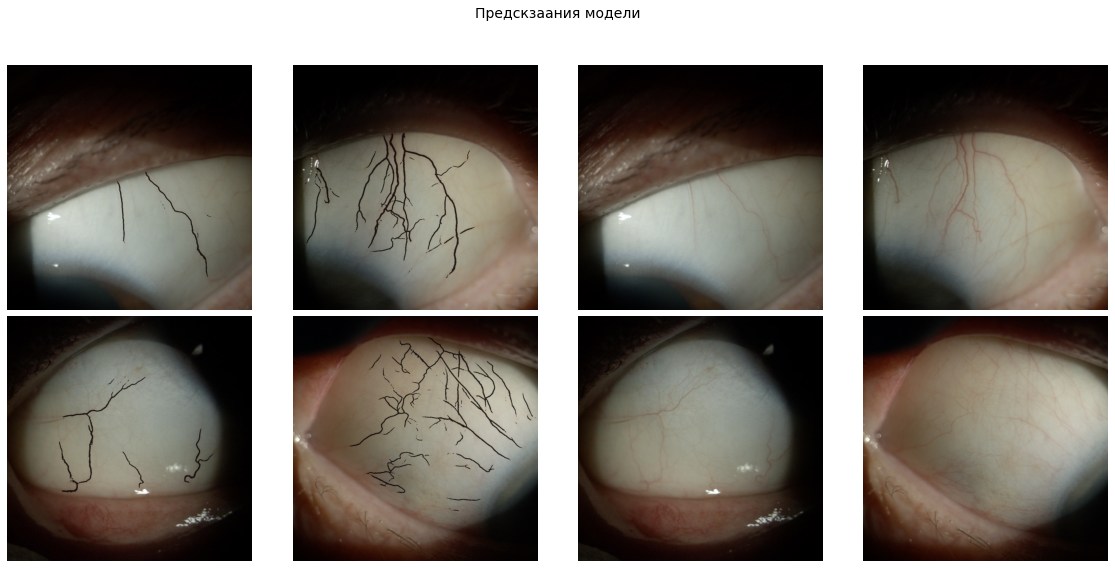

In [24]:
fig, axs = plt.subplots(2, 4, figsize=(16,8))
fig.suptitle(f'Предскзаания модели', fontsize=14)

for i, sample in zip(range(4), test_dataset):
    image = sample['image'].to("cuda")

    image = (image.cpu() * 255).type(torch.uint8)
    pred_ask = (torch.exp(test_pred[i]) > 0.5).cpu().squeeze()

    image_with_mask = draw_segmentation_masks(image, pred_ask)
    image_with_mask = np.moveaxis(image_with_mask.cpu().numpy(), 0, -1)

    axs[i // 2, (i % 2)].imshow(image_with_mask)
    axs[i // 2, (i % 2)].axis('off')

    image = np.moveaxis(image.cpu().numpy(), 0, -1)
    axs[i // 2, (i % 2)+2].imshow(image)
    axs[i // 2, (i % 2)+2].axis('off')


fig.tight_layout()
fig.subplots_adjust(top=0.88)

In [25]:
import os
directory = "./predicted"

In [26]:
import glob
file_names = os.listdir("test/eye_test/")

In [27]:
for i, torch_tensor in enumerate(test_pred):
  im = torch_tensor.sigmoid().cpu().squeeze().numpy()
  im = np.where(im > 0.5, 1, 0)
  im = A.PadIfNeeded(1232, 1624, border_mode = cv2.BORDER_CONSTANT, value = 0)(image = im)['image']
  cv2.imwrite(os.path.join(directory, file_names[i]), im*255)

In [28]:
!zip -r -j zipped/Unet_resnet50_10ep.zip ./predicted/*

  adding: 1001.png (deflated 23%)
  adding: 1002.png (deflated 23%)
  adding: 1003.png (deflated 20%)
  adding: 1004.png (deflated 27%)
  adding: 1005.png (deflated 20%)
  adding: 1007.png (deflated 17%)
  adding: 1008.png (deflated 23%)
  adding: 1009.png (deflated 34%)
  adding: 1010.png (deflated 22%)
  adding: 1011.png (deflated 29%)
  adding: 1012.png (deflated 29%)
  adding: 1013.png (deflated 31%)
  adding: 1014.png (deflated 31%)
  adding: 1015.png (deflated 23%)
  adding: 1016.png (deflated 23%)
  adding: 1017.png (deflated 30%)
  adding: 1018.png (deflated 42%)
  adding: 1019.png (deflated 19%)
  adding: 1020.png (deflated 22%)
  adding: 1022.png (deflated 21%)
  adding: 1023.png (deflated 57%)
  adding: 1024.png (deflated 21%)
  adding: 1025.png (deflated 30%)
  adding: 1026.png (deflated 31%)
  adding: 1027.png (deflated 44%)
  adding: 1028.png (deflated 31%)
  adding: 1029.png (deflated 23%)
  adding: 1031.png (deflated 29%)
  adding: 1032.png (deflated 21%)
  adding: 1033